# Raisin prediction using Bayesian Networks
FAIKR module 3 project, done by Michele Calvanese, Samuele Marino  

## Introduction

The goal of this exploratory study was to develop and assess a prediction model which can potentially be used as a biomarker of breast cancer, based on anthropometric data and parameters which can be gathered in routine blood analysis.

For each of the 116 participants several clinical features were observed or measured, including age, BMI, Glucose, Insulin, HOMA, Leptin, Adiponectin, Resistin and MCP-1


Attribute Information:


1. Age(years): The age of the participant
2. BMI(kg/m2): is a measure of body size. It combines a person’s weight with their height.
3. Glucose(mg/dL): is a simple sugar which is an important energy source in living organisms
4. Insulin(µU/mL): is a hormone made in your pancreas, a gland located behind your stomach.
5. HOMA: is a method for assessing β-cell function and insulin resistance (IR) from basal (fasting) glucose and insulin or C-peptide concentrations.
6. Leptin(ng/mL): is a hormone your body releases that helps it maintain your normal weight on a long-term basis.
7. Adiponectin(µg/mL): is a protein hormone that is produced by fat cells.
8. Resistin(ng/mL): is a cysteine-rich hormone secreted from white adipocytes.
9. MCP-1(pg/dL): is one of the key chemokines that regulate migration and infiltration of monocytes/macrophages.

Dataset [link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra).

In [73]:
import pandas as pd
import numpy as np
import pgmpy
import networkx as nx
import pylab as plt
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, BDsScore, K2Score, BicScore, BDeuScore, MaximumLikelihoodEstimator, BayesianEstimator
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout


## Data cleaning and preparation

All attributes were used for making the Bayesian Network model. Before creating the model, all the attributes need to be discretized, as the pgmpy library only works with discrete variables.

In [74]:
path = "./Dataset/dataR2.xlsx"
data = pd.read_excel(path)
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [75]:
data.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [76]:
data.shape

(116, 10)

Before modifying the variables, dataset is checked for the presence of N/A values.

In [77]:
data.isnull().sum()

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

So there is no N/A values

### Variable discretization

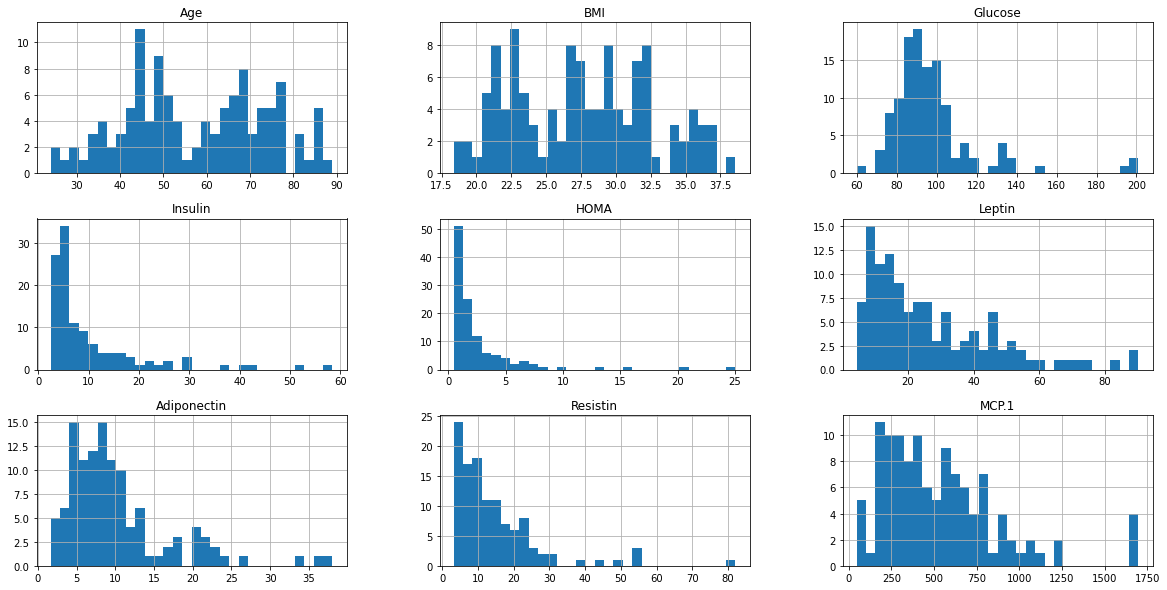

In [78]:
data.drop('Classification', axis=1).hist(bins=30, figsize=(20, 10));

#### Age

In [79]:
min = data['Age'].min()
max = data['Age'].max()

data['Age'] = pd.cut(x=data['Age'], bins=[min-1, 40, 55, 80, max], labels=["24-39", "39-54", "55-79", "80+"])

#### BMI

BMI is a measurement of a person's leanness or corpulence based on their height and weight, and is intended to quantify tissue mass. It is widely used as a general indicator of whether a person has a healthy body weight for their height. Specifically, the value obtained from the calculation of BMI is used to categorize whether a person is underweight, normal weight, overweight, or obese depending on what range the value falls between.

This is the World Health Organization's ([WHO](https://www.who.int/)) recommended body weight based on BMI values for adults. It is used for both men and women, age 18 or older:

- Thinness: < 18.5
- Normal: >= 18.5 and < 25
- Overweight: >= 25 < 30
- Obese Class: >= 30

In [80]:
data['BMI'] = pd.cut(x=data['BMI'], 
                     bins=[0, 18.5, 25, 30, 100], 
                     labels=["Thinness", "Normal","Overweight", "Obese Class"])


#### Glucose

According to [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451), for the majority of healthy individuals, normal blood sugar levels are as follows: 

- Normal: Below  140 mg/dL
- Prediabetes: 140 and 199 mg/dl
- Diabetes: 200 mg/dL


In [81]:
data['Glucose'] = pd.cut(x=data['Glucose'], 
                         bins=[0, 70, 120, 300], 
                         labels=["Normal", "Prediabetes", "Diabetes"])

#### Insulin

According [MedScape](https://emedicine.medscape.com/article/2089224-overview#a1), for the majority of healthy individuals, normal blood insulin levels are as follows:

- Normal: < 25(µU/mL)
- High: >= 25(µU/mL)

In [82]:
data['Insulin'] = pd.cut(x=data['Insulin'], bins=[0, 25, 100], labels=["normal", "high"])

#### HOMA

Different [studies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3890224/) provide slightly different ranges for HOMA. But they all agree that the higher your HOMA gets, the more insulin resistant you are.

Generally, you have optimal insulin sensitivity if your HOMA is less than 10. Levels above 19 signal early insulin resistance, while levels above 29 signal significant insulin resistance.

In [83]:
data['HOMA'] = pd.cut(x=data['HOMA'], 
                      bins=[0, 10, 29, 50], 
                      labels=["insulin sensitivity", "insulin resistance", "significant insulin resistane"])

#### Leptin

From cross-sectional [study](https://www.sciencedirect.com/science/article/abs/pii/S0300893214006113) conducted from 2008 to 2010 on 11,540 individuals representative of the Spanish population aged ≥ 18 years it is clear that leptin values were higher in women than in men (geometric mean, 21.9 and 6.6 ng/ml; p < 0.001). In women, the median [interquartile range] was 24.5 [14.1-37.0] ng/ml.

In [84]:
data['Leptin'] = pd.cut(x=data['Leptin'], 
                        bins=[0, 14.1, 37.0, 150], 
                        labels=["low", "medium", "high"])

#### Adiponectin

According [(POP-ABC) study](https://drc.bmj.com/content/4/1/e000194), for the majority of healthy individuals, normal blood adiponectin levels are as follows:

- Low: <3(µg/mL)
- Normal: >= 3(µg/mL) and < 30(µU/mL)
- High: >= 30(µU/mL)



In [85]:
data['Adiponectin'] = pd.cut(x=data['Adiponectin'], bins=[0, 15, 30, 50], labels=["low", "medium", "high"])

#### Resistin

According [The Journal of Clinical Endocrinology & Metabolism](https://doi.org/10.1210/jc.2005-2115), for the majority of healthy individuals, normal blood resistin levels are as follows:

- Normal: < 9(µU/mL)
- High: >= 30(µU/mL)


In [86]:
data['Resistin'] = pd.cut(x=data['Resistin'], bins=[0, 29, 100], labels=["low", "high"])

#### MCP.1
According Toni Valković's [study](https://doi.org/10.1155/2016/7870590), for the majority of healthy individuals, normal blood MCP-1 levels are as follows:

- Low: < 500(pg/dL)
- Medium: >= 500(pg/dL) and < 1200(pg/dL)
- High: >= 1200(pg/dL)



In [87]:
data['MCP.1'] = pd.cut(x=data['MCP.1'], bins=[0, 500, 1200, 2000], labels=["low", "medium", "high"])

In [88]:
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,39-54,Normal,Normal,normal,insulin sensitivity,low,low,low,low,1
1,80+,Normal,Prediabetes,normal,insulin sensitivity,low,low,low,low,1
2,80+,Normal,Prediabetes,normal,insulin sensitivity,medium,medium,low,medium,1
3,55-79,Normal,Prediabetes,normal,insulin sensitivity,low,low,low,medium,1
4,80+,Normal,Prediabetes,normal,insulin sensitivity,low,low,low,medium,1


##  Bayesian Network

### Learning the structure of the network and analyzing it 

One option for defining the structure of the network would be to manually add the nodes and connections between them. Knowing the connections between nodes requires having a sufficient knowledge about the field of application in order to be able to define conditional independence assertions. 

Luckily, pgmpy library offers many ways for learning a structure for discrete, fully observed networks. Given a set of data samples, the algorithm estimates a directed acyclic graph that captures dependencies between the variables. We will use Score-based structure estimation that learns the model as an optimization task, and which lets the programmer choose a search strategy and a scoring function which will be used.

Some of the available search strategies are:

- Exhaustive search
- Hill Climb search

The search space is super-exponential in the number of variables, which is the reason why Exhaustive search wasn't chosen for this particular project. However, for a very small number of nodes, it is guaranteed to find the best-scoring graph. When networks are bigger it is better to use Hill Climb search, which implements a greedy local search starting usually from a disconnected graph. In every iteration it makes one change on edges of the graph that maximally increases the score.

However, this approach often leads to inconsistent results: the node Classification may have exiting edges (which we do not want, because this is the attribute we want to predict), or multiple disconnected graphs may be found. We therefore remove all the edges that have Classification as parent and the ones that have Age as child. In addition, according to [scientific medical sources](https://bmccancer.biomedcentral.com/track/pdf/10.1186/s12885-017-3877-1.pdf), we force the learning algorithm to include the following edges in the network: ('Age', 'Classification'), ('Glucose', 'Classification'), ('Leptin', 'Classification'), ('MCP.1', 'Classification), ('Resistin', 'Classification').


In [89]:
black_list = [('Classification', attribute) for attribute in data.columns[:-1]] + [(attribute, 'Age') for attribute in data.columns[:-1]]

fixed_edges = [('Age', 'Classification'), ('Glucose', 'Classification'), ('Leptin', 'Classification'),
               ('MCP.1', 'Classification'), ('Resistin', 'Classification'), ]

#learning the stucutre of the network
est = HillClimbSearch(data, use_cache=False)
best_model = est.estimate(scoring_method=BDsScore(data),
                          black_list=black_list,
                          fixed_edges=fixed_edges
                          )


  0%|          | 7/1000000 [00:02<82:24:40,  3.37it/s] 


In [90]:
#the estimated model returns a DAG at a (local) score maximum
edges = list(best_model.edges())
model = BayesianNetwork(edges)

#nodes of the model
model.nodes

NodeView(('Age', 'Classification', 'BMI', 'Adiponectin', 'Glucose', 'Leptin', 'Insulin', 'HOMA', 'Resistin', 'MCP.1'))

In [91]:
#edges of the model
model.edges

OutEdgeView([('Age', 'Classification'), ('BMI', 'Adiponectin'), ('Glucose', 'Classification'), ('Glucose', 'Leptin'), ('Leptin', 'Classification'), ('Leptin', 'BMI'), ('Insulin', 'HOMA'), ('HOMA', 'Glucose'), ('HOMA', 'Resistin'), ('HOMA', 'MCP.1'), ('Resistin', 'Classification'), ('MCP.1', 'Classification')])

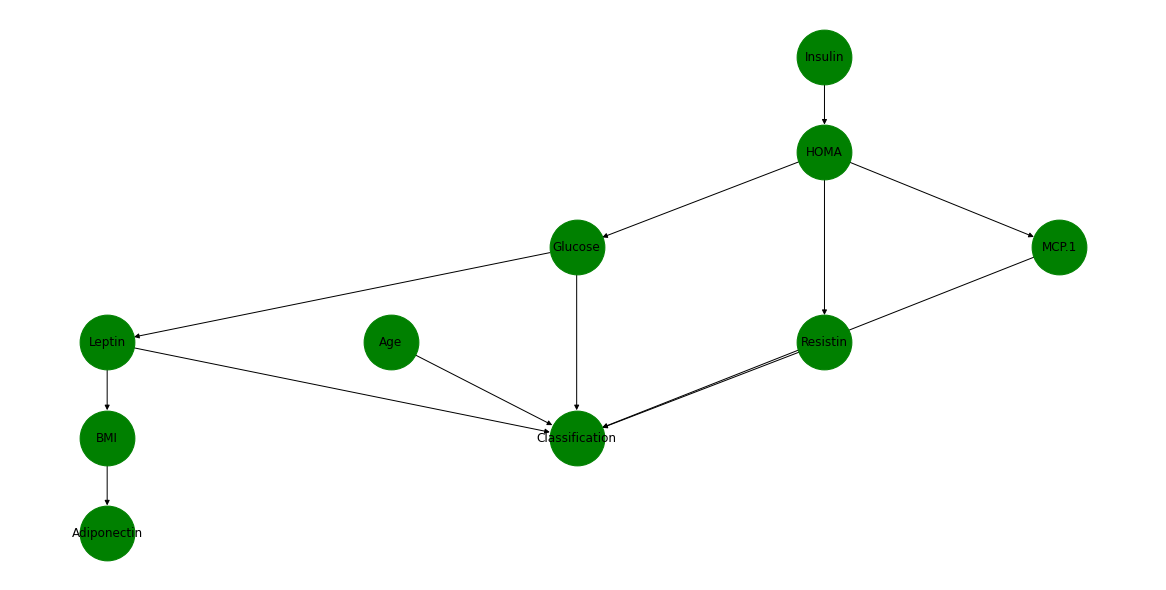

In [92]:
pos = graphviz_layout(model, prog="dot")
plt.figure(figsize=(16, 8))
nx.draw(model, with_labels=True, pos=pos, node_size=3000, node_color="green")
# plt.savefig('model.png')
plt.show()

### Learning the parameters of the network

As mentioned before, pgmpy currently supports parameter learning only for networks with discrete nodes. There are 2 available methods for determining the values of the conditional probability distributions:
- Maximum Likelihood estimation.

       This method uses relative frequencies for estimating conditional probabilities. However, in case of small datasets it is prone to overfitting.
- Bayesian estimation.

       On the other hand, Bayesian estimator assumes prior CPDs on variables and then updates them using state counts from observed data.
Because our dataset has only 116 samples we use __Bayesian estimation__

In [93]:
model.fit(data=data, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, 2*'\n', 80*"=", '\n')


CPT of Age:
+------------+-----------+
| Age(24-39) | 0.150826  |
+------------+-----------+
| Age(39-54) | 0.349174  |
+------------+-----------+
| Age(55-79) | 0.407025  |
+------------+-----------+
| Age(80+)   | 0.0929752 |
+------------+-----------+ 


CPT of Classification:
+-------------------+-----+----------------------+
| Age               | ... | Age(80+)             |
+-------------------+-----+----------------------+
| Glucose           | ... | Glucose(Prediabetes) |
+-------------------+-----+----------------------+
| Leptin            | ... | Leptin(medium)       |
+-------------------+-----+----------------------+
| MCP.1             | ... | MCP.1(medium)        |
+-------------------+-----+----------------------+
| Resistin          | ... | Resistin(low)        |
+-------------------+-----+----------------------+
| Classification(1) | ... | 0.5                  |
+-------------------+-----+----------------------+
| Classification(2) | ... | 0.5                  |
+----

Checking if it has errors

In [94]:
model.check_model()

True

Cardinality of all model nodes

In [95]:
model.get_cardinality()

defaultdict(int,
            {'Age': 4,
             'Classification': 2,
             'BMI': 4,
             'Adiponectin': 3,
             'Glucose': 3,
             'Leptin': 3,
             'Insulin': 2,
             'HOMA': 2,
             'Resistin': 2,
             'MCP.1': 3})

Checking the markov blanket for Classification  and Glucose

In [96]:
print("Markov blanket for variable:")
print("Classification: ", model.get_markov_blanket("Classification"))
print("Glucose: ", model.get_markov_blanket("Glucose"))

Markov blanket for variable:
Classification:  ['Leptin', 'Resistin', 'Age', 'Glucose', 'MCP.1']
Glucose:  ['Resistin', 'Age', 'Classification', 'HOMA', 'Leptin', 'MCP.1']
